# <div style="padding:20px;color:white;margin:0;font-size:36px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#016FD0;overflow:hidden">Retail Site Promotion A/B Testing</div>
### <font color=#4D4D4D>Warren Silva</font>
---

This is a sample A/B testing project. The functions defined below are intended to be highly reusable, and are designed with the flexibility to accept data sets with either a binary or a continuous target variable. The example project that follows will analyze both scenarios. 

The key features of this script include:

- **<font color=black>Programmatic detection of target variable type (binary or continuous)</font>**
- **<font color=black>Conditional evaluations and execution of appropriate statistical tests based on several factors </font>**
- **<font color=black>Interpretation logic for accepting/rejecting the null hypothesis of group similarity</font>**

## Campaign Overview and Objectives
---
*The scenario and company referenced here are fictitious, as is the data. The sample was generated using a script developed by the author.*

A retail website routinely offers the same promotion to 
first-time visitors, to drive purchase activity. They recently ran a campaign where new visitors were randomly offered an alternative promotion. The campaign aims to uncover two things:
1. **<font color=green>Which promotion leads to a higher rate of purchase?</font>**
2. **<font color=green>Among visitors who make a purchase, which group spends more?</font>**

## Setup
---

First, we import the necessary libraries, load and preview the data.

In [1]:
# import libraries and config
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats

# display options
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.3f}'.format

## Exploratory Data Analysis, Cleaning, and Feature Engineering

In [2]:
# load and preview data
df = pd.read_csv('sample_data.csv')

# function for balanced preview sample
def sample_data(data, col_name, records=5):
    df1 = data[data[col_name] > 0].sample(n=records // 2, random_state=1, replace=True)
    df2 = data[data[col_name] == 0].sample(n=records - len(df1), random_state=1, replace=True)
    df_sample = pd.concat([df1, df2]).sample(frac=1, random_state=1).reset_index(drop=True)
    display(df_sample)

In [3]:
sample_data(df,'outcome')

,id,date,group,outcome
0,uy106854,9/30/23,treatment,0.000
1,bq127357,12/18/23,treatment,122.305
2,nm97738,12/24/23,control,0.000
3,hp94120,11/7/23,control,13.605
4,bk55009,10/21/23,treatment,0.000


<u>**Data Description**</u>

- <code>id</code> - Unique identifier for visitor
- <code>date</code> - Date of visit
- <code>group</code> - Indicator for which promotion was offered:
    - A value of 'control' means the standard promotion was offered
    - A value of 'treatment' means the alternative promotion was offered
- <code>outcome</code> - The amount spent on the current visit

Recall that we have two questions to answer, which means we will ultimately run two seperate A/B tests, each with the appropriate target variable: 

> **<font color=green>1. Which promotion leads to a higher rate of purchase?</font>**
>> For this first question, we will need to create a binary indicator to distinguish purchases from non-purchases.

> **<font color=green>2. Among visitors who make a purchase, which group spends more?</font>**   
>> The existing <code>outcome</code> variable will satisfy the need for this one.

To aid with question #1, we'll add a variable called <code>did_purchase</code> and set the value:
- to **<font color=green>1</font>** (True) if a purchase was made (where <code>outcome</code> is greater than zero)
- to **<font color=green>0</font>** (False) in all other cases

In [4]:
# binary indicator for purchase
df['did_purchase'] = np.where(df['outcome'] > 0, 1, 0)

In [5]:
sample_data(df,'did_purchase')

,id,date,group,outcome,did_purchase
0,uy106854,9/30/23,treatment,0.000,0
1,bq127357,12/18/23,treatment,122.305,1
2,nm97738,12/24/23,control,0.000,0
3,hp94120,11/7/23,control,13.605,1
4,bk55009,10/21/23,treatment,0.000,0


Next, we'll get some more detailed summary statistics about our data.

In [6]:
# summary stats function
def summarize(df):
    # summary dataframes
    df_type = pd.DataFrame(df.dtypes, columns=['data type'])
    df_null = pd.DataFrame(df.isnull().sum(), columns=['null_count'])
    df_null['null_pct'] = df.isnull().mean() * 100
    df_unique = pd.DataFrame(df.nunique(), columns=['unique'])
    df_stats = df.describe(include='all', datetime_is_numeric=True).transpose()
    df_stats = df_stats[['top', 'freq', 'min', 'max', 'mean', 'std']]
    
    # combine
    df_summary = pd.concat([df_type, df_null, df_unique, df_stats], axis=1)
    
    # add dup row count
    duplicate_rows = df.duplicated().sum()
    df_summary.loc['duplicate rows'] = duplicate_rows
    
    # print results
    print(f'record count: {df.shape[0]}')
    print(f'column count: {df.shape[1]}')
    print()
    print('Data Summary:')
    display(df_summary)
    
    return None

# get summary stats
summarize(df)

record count: 100000
column count: 5

Data Summary:


,data type,null_count,null_pct,unique,top,freq,min,max,mean,std
id,object,0,0.000,99100,or71985,3,NaN,NaN,NaN,NaN
date,object,0,0.000,152,8/8/23,729,NaN,NaN,NaN,NaN
group,object,0,0.000,2,treatment,51628,NaN,NaN,NaN,NaN
outcome,float64,0,0.000,3645,NaN,NaN,0.000,2279.774,3.252,23.189
did_purchase,int64,0,0.000,2,NaN,NaN,0.000,1.000,0.036,0.187
duplicate rows,3,3,3.000,3,3,3,3,3,3,3


<u>**Observations**</u>
- Control and treatment groups are reasonably balanced with the treatment group representing a little over 51% of the data
- There are fewer unique <code>id</code> values than there are total records, which suggests that there are multiple records for some visitors.
- There are also a few records where all values are duplicated.
- There is a large difference between the mean and the max outcome, suggesting we probably have some extreme outliers in our data.

We'll do a little bit of cleaning with the information uncovered from these stats. 

Firstly, since the business problem is concerned with first-time visitors only, we will drop records for subsequent visits for the same <code>id</code> value, keeping only the record with the earliest <code>date</code> value.

In [7]:
# duplicate id sample
df[df['id'] == 'or71985'].sort_values('date')

,id,date,group,outcome,did_purchase
56546,or71985,10/28/23,treatment,0.000,0
56547,or71985,11/8/23,treatment,110.903,1
56545,or71985,8/13/23,treatment,0.000,0


Oops! Our data didn't sort as expected because <code>date</code> is stored as an object. Let's correct that.

In [8]:
# convert 'date' to a datetime
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')

In [9]:
# duplicate id sample
df[df['id'] == 'or71985'].sort_values('date')

,id,date,group,outcome,did_purchase
56545,or71985,2023-08-13,treatment,0.000,0
56546,or71985,2023-10-28,treatment,0.000,0
56547,or71985,2023-11-08,treatment,110.903,1


In [10]:
# keep only first visit for each unique id
df = df.sort_values(['id', 'date'])
df = df.drop_duplicates(subset='id', keep='first').reset_index(drop=True)

Let's get a little bit of a more detailed picture of how <code>outcome</code> (purchase amount) is distributed. To focus in on the business problem, we'll look at only records where there was a sale.

In [11]:
# sales amount percentiles
df_sales = df[df['did_purchase']==1]
df_sales['outcome'].describe()

count   3615.000
mean      89.211
std       84.422
min        4.691
25%       45.149
50%       85.223
75%      126.341
max     2279.774
Name: outcome, dtype: float64

We can see that the average sale amount is about \\$89, and 75\% of sales are less than\\$127. But in rarer cases, some visitors spend much, much more. Let's visualize some of these outliers to get a better sense of just how rare these cases are.

In [12]:
# boxplot function
def make_boxplot(dataframe, top_val=None):
    plt.figure(figsize=(5, 7))
    # set color for outliers
    flierprops = dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none')
    ax = sb.boxplot(data=dataframe, whis=2.0, color='blue', flierprops=flierprops)
    if top_val:
        ax.set_ylim(bottom=1, top=top_val)

    # set color for IQR and whiskers
    for patch in ax.artists:
        patch.set_edgecolor('blue')
        patch.set_facecolor('blue')
    for line in ax.lines:
        line.set_color('blue')
    plt.show()

Here is a brief overview of how we interpret a boxplot:
- The solid area of the boxplot represents the interquartile range (IQR), which spans everything between the 25th and 75th percentile. More simply, it is the "middle half" of the data.
- The lines, or "whiskers" that extend above and below the IQR are meant to capture everything that falls within a "reasonable" distance from the mean. In this case we have defined "reasonable distance" as twice the size of the IQR (by passing <code>whis=2.0</code> to our boxplot function), which is a common threshold when considering the statistical dispersion of continuous data that might contain outliers. 

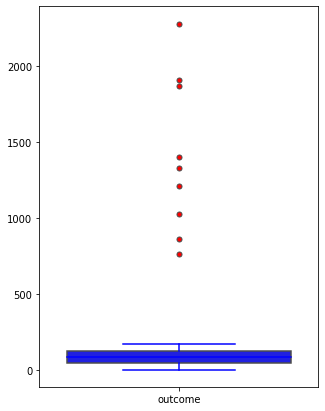

In [13]:
make_boxplot(df_sales[['outcome']])

Visually, we can pretty easily see that there are just a handful of pretty extreme values relative to the bulk of the data. Let's try focusing in on the more common outcomes. We'll do this by providing a value for the <code>top</code> argument we built into our boxplot function.

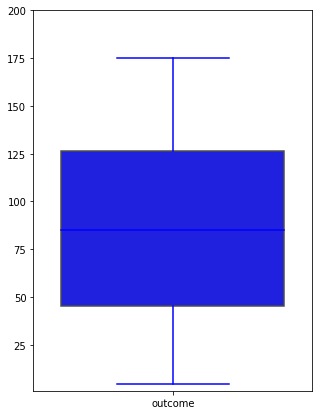

In [14]:
make_boxplot(df_sales[['outcome']], 200)

That gives a much clearer picture of how the majority of the sales are distributed. 

We can easily see that the vast majority of sales are under about \\$175, and the interquartile range, representing everything between the 25th and 75th percentile, includes sales roughly between \\$50 and \\$125.  If we want to get some more precise numbers for the sake of discussion, we can calculate those:

In [15]:
# calculate IQR and related components
q1 = df_sales['outcome'].quantile(0.25)
q3 = df_sales['outcome'].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - 2 * iqr
upper_limit = q3 + 2 * iqr
lower_whis = df_sales['outcome'][df_sales['outcome'] >= lower_limit].min()
upper_whis = df_sales['outcome'][df_sales['outcome'] <= upper_limit].max()

print(f'Lowest reasonable actual value: ${lower_whis:.2f}')
print(f'25th percentile: ${q1:.2f}')
print(f'75th percentile: ${q3:.2f}')
print(f"Highest reasonable actual value: ${upper_whis:.2f}")

Lowest reasonable actual value: $4.69
25th percentile: $45.15
75th percentile: $126.34
Highest reasonable actual value: $174.99


Let's quickly look at the count of our outliers and their ratio to the rest of the data.

In [16]:
# check outlier count and proportion
sales_count = len(df_sales)
outlier_count = len(df_sales[df_sales['outcome']>500])
outlier_pct = (outlier_count / sales_count) * 100

print(f'There are {outlier_count} outliers out of {sales_count} sales, representing {outlier_pct:.3f}% of the data')

There are 9 outliers out of 3615 sales, representing 0.249% of the data


As suspected, these outliers represent a very rare case, and it makes sense to remove them from our analysis so as not to skew the results of our test or any calculations for mean sales, which we are likely to be interested in when presenting our outcomes.

The outliers in this problem may seem pretty cut and dry, but that is not always the case. In the event we wanted to take a more programmatic approach to outlier detection and pruning, here is an alternative method that utilizes z_score.

In [17]:
# function for outlier detection with z-score
def show_outliers(data, col_name, threshold=3):
    d1 = data[col_name].values
    mean = np.mean(d1)
    std = np.mean(d1)
    z_score = np.abs((d1 - mean) / std)
    good = z_score < threshold

    print(f'Rejection of {(~good).sum()} points')
    print(f'A z-score of {threshold} corresponds to a probability of {100 * 2 * stats.norm.sf(threshold):0.2f}%')

    visual_scatter = np.random.normal(size=d1.size)
    plt.figure(figsize=(12, 8))
    plt.scatter(d1[good], visual_scatter[good], s=2, label='Good', color='#4CAF50')
    plt.scatter(d1[~good], visual_scatter[~good], s=8, label='Bad', color='#F44336')
    plt.show()
    
    return good

Rejection of 9 points
A z-score of 3 corresponds to a probability of 0.27%


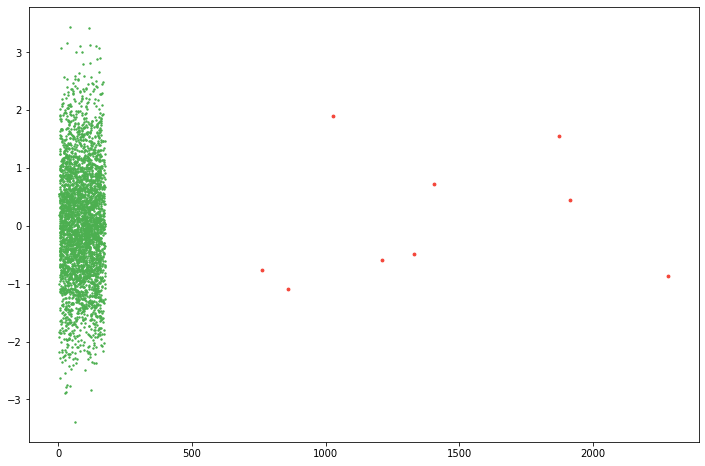

In [18]:
good = show_outliers(df_sales,'outcome')

In [19]:
# drop outliers
outlier_indices = df_sales.index[~good]
df = df.drop(outlier_indices).reset_index(drop=True)
df_sales = df_sales.drop(outlier_indices).reset_index(drop=True)

## Run A/B Tests
---
Here we have written a flexible function to run our A/B test, evaluating several characteristics of the data along the way, and executing the most appropriate tests. 

Here is a visual representation of the workflow:

![A/B Test Workflow Diagram](ab_test_workflow.png)

<u>**Brief Overview of Hypothesis Testing**</u>

In statistical tests, we either reject or accept (fail to reject) the **null hypothesis**. In very simple terms, the null hypothesis suggests that there is no significant difference between two groups, and that any variance in the results are likely due to chance.

We use a statistical measure called a **p-value** to guage whether or not any observed difference is really due to the treatment (or lack thereof) within each group. We typically interpret any p-value less than 0.05 as statistically significant, and the smaller the p-value, the stronger the evidence in support of the **alternative hypothesis**: that the treatment has a real effect on the outcome.

In [20]:
# a/b testing function for binary or continuous targets
def ab_test(df_in, group, target):
    # split a/b populations
    df_a = df_in[df_in[group] == 'treatment'][target]
    df_b = df_in[df_in[group] == 'control'][target]
    
    # check if the target variable is binary
    is_binary = df_in[target].nunique() == 2
    
    if is_binary:
        print('Target variable is binary') 
        
        # create contingency table
        contingency_table = pd.crosstab(df_in[group], df_in[target])
        
        # decide between Chi-Square and Fisher's Exact test based on sample size 
        if df_in.shape[0] >= 1000:
            print('Running Chi-Square test (sample size is >= 1000)')
            chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
            test_type = 'Chi-Square Test'
        else:
            print('Running Fisher\'s Exact test (sample size is < 1000)')
            _, p_value = stats.fisher_exact(contingency_table)
            test_type = 'Fisher\'s Exact Test'
        
        # interpret results
        ab_outcome = 'Reject' if p_value < 0.05 else 'Fail to Reject'
        comment = 'Difference is statistically significant' if ab_outcome == 'Reject' else 'Difference not significant'
        
        # output dataFrame
        df_out = pd.DataFrame({
            'Test Type': [test_type],
            'Null Hypothesis': [ab_outcome],
            'p-value': [p_value],
            'Comment': [comment]
        })
    
    else:
        # normality test
        if (len(df_a) < 5000) & (len(df_b) < 5000):
            print('Running Shapiro-Wilk normality test (sample size is < 5000)')
            norm_a = stats.shapiro(df_a)[1] < 0.05
            norm_b = stats.shapiro(df_b)[1] < 0.05
        else:
            print('Running Kolmogorov-Smirnov normality test (sample size is > 5000)')
            norm_a = stats.kstest(df_a, 'norm')[1] < 0.05
            norm_b = stats.kstest(df_b, 'norm')[1] < 0.05

        if (norm_a == False) & (norm_b == False):  # Parametric Test
            leveneTest = stats.levene(df_a, df_b)[1] < 0.05
            if leveneTest == False:
                ttest = stats.ttest_ind(df_a, df_b, equal_var=True)[1]
            else:
                ttest = stats.ttest_ind(df_a, df_b, equal_var=False)[1]
        else:
            # non-parametric test
            ttest = stats.mannwhitneyu(df_a, df_b)[1]

        # result for continuous data
        df_out = pd.DataFrame({
            'Null Hypothesis': [ttest < 0.05],
            'p-value': [ttest]
        })
        df_out['Test Type'] = np.where((norm_a == False) & (norm_b == False), 'Parametric', 'Non-Parametric')
        df_out['Null Hypothesis'] = np.where(df_out['Null Hypothesis'] == False, 'Fail to Reject', 'Reject')
        df_out['Comment'] = np.where(df_out['Null Hypothesis'] == 'Fail to Reject', 
                                     'Difference not significant', 'Difference is statistically significant')

        # additional homogeneity column for parametric tests
        if (norm_a == False) & (norm_b == False):
            df_out['Homogeneity'] = np.where(leveneTest == False, 'Yes', 'No')
            df_out = df_out[['Test Type', 'Homogeneity', 'Null Hypothesis', 'p-value', 'Comment']]
        else:
            df_out = df_out[['Test Type', 'Null Hypothesis', 'p-value', 'Comment']]
    
    return df_out

# update precision for p-value
pd.options.display.float_format = '{:.5f}'.format

# Produce and Interpret Results

## <font color=green>Business Question 1: Which promotion leads to a higher rate of purchase?</font>

First, let's look at the average purchase rate within each group.

In [21]:
# view mean purchase amounts by group
display(df.groupby('group')['did_purchase'].mean().mul(100).round(2).astype(str) + '%')

group
control      3.77%
treatment    3.51%
Name: did_purchase, dtype: object

We see that in our sample, the average rate of purchase for visitors offered the standard promotion is <font color=green>3.77%</font>, compared to <font color=green>3.51%</font> for visitors exposed to the alternative promotion. 

The numbers are different and appear to be in favor of the standard promotion, but we need to make sure the difference is statistically significant, which we can validate or disprove with our A/B test.

In [22]:
# run A/B test on purchase rate
ab_test(df, 'group', 'did_purchase')

Target variable is binary
Running Chi-Square test (sample size is >= 1000)


,Test Type,Null Hypothesis,p-value,Comment
0,Chi-Square Test,Reject,0.02872,Difference is statistically significant


### <font color=purple>Business Question 1 Outcome</font>

Our p-value of **<font color=green>0.02872</font>** indicates that there is a statistically significant difference between our two populations, which tells us that we can anticipate that continued use of the alternative promotion is likely to produce a **lower** rate of purchase. 

## <font color=green>Business Question 2: Among visitors who make a purchase, which group spends more?</font>

As we did last time, we'll first check the average spend between each group. Note that we are only looking at visitors who did in fact make purchases within each group.

In [23]:
display(df_sales.groupby('group')['outcome'].mean().apply(lambda x: f"${x:,.2f}"))

group
control      $88.48
treatment    $83.35
Name: outcome, dtype: object

Once again, we can see a difference with an average purchase amount of <font color=green>\$88.48</font> in the standard promotion group, and <font color=green>\$83.35</font> when the alternative promotion is offered.

Let's run our A/B test to check for statistical significance.

In [24]:
# run A/B test on purchase amount
ab_test(df_sales, 'group', 'outcome')

Running Shapiro-Wilk normality test (sample size is < 5000)


,Test Type,Null Hypothesis,p-value,Comment
0,Non-Parametric,Reject,0.00240,Difference is statistically significant


### <font color=purple>Business Question 2 Outcome</font>

Here we have a very low p-value of **<font color=green>0.00240</font>**, which signifies that the alternative promotion is driving a **lower** overall customer spend. 

# <font color=green>Conclusion</font>

After analyzing and testing the campaign data, we have statistical evidence that the standard promotion performs better for both rate of purchase and purchase amount. Our retail company is likely well-advised to continue with the standard promotion they have historically offered to new visitors, or to run a new campaign with a different alternative promotion if they wish to drive even higher sales.